<a href="https://colab.research.google.com/github/akashasd/project/blob/main/prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

PermutationExplainer explainer: 9001it [1:23:17,  1.80it/s]


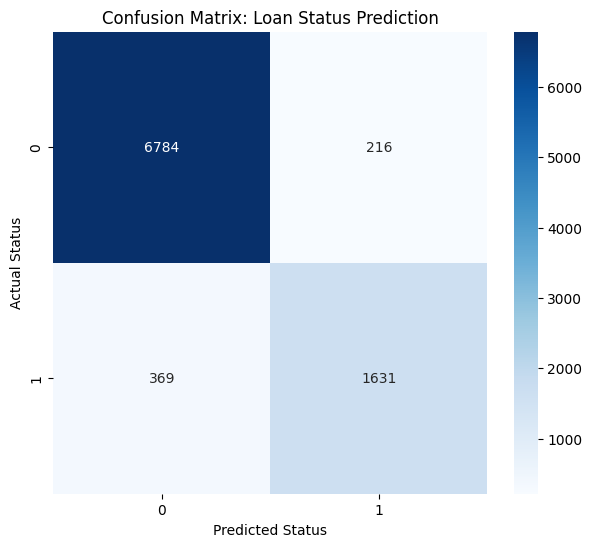

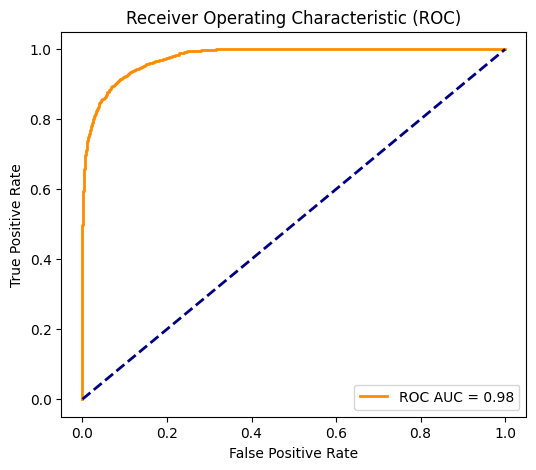

/tmp/ipython-input-487498806.py:159: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_summary_values, X_test_transformed, feature_names=all_feature_names, show=False)
/usr/local/lib/python3.12/dist-packages/shap/plots/_beeswarm.py:723: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  summary_legacy(
/usr/local/lib/python3.12/dist-packages/shap/plots/_beeswarm.py:743: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  summary_legacy(


<Figure size 640x480 with 0 Axes>

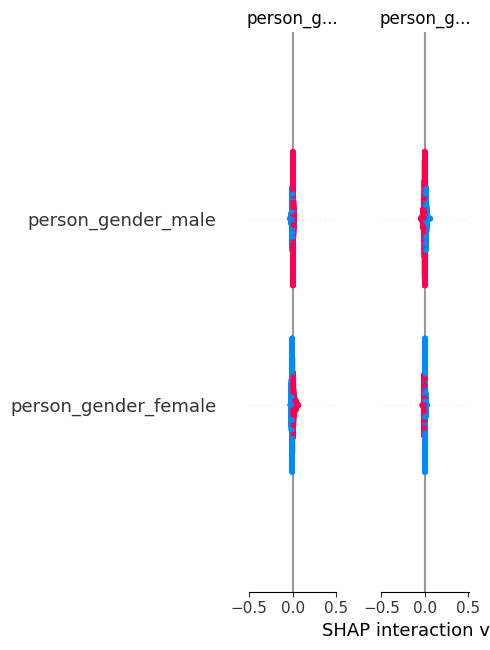

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve

# Re-import necessary libraries and re-run initial steps to define variables
# This assumes the dataset 'archive (3).zip' is available in /content/
# If not, please ensure it's uploaded or the path is correct.

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
import shap

# 2) Load dataset (re-run)
try:
    df = pd.read_csv("/content/archive (4).zip")
except FileNotFoundError:
    print("Error: Dataset not found. Please upload 'archive (3).zip' to /content/ or update the path.")
    # Create dummy data for demonstration if file not found
    dummy_data_size = 1000
    df = pd.DataFrame({
        'feature_num_1': np.random.rand(dummy_data_size),
        'feature_num_2': np.random.rand(dummy_data_size),
        'feature_cat_1': np.random.choice(['A', 'B', 'C'], size=dummy_data_size),
        'loan_status': np.random.choice([0, 1], size=dummy_data_size, p=[0.7, 0.3])
    })

# 3) Features & Target (re-run)
X = df.drop("loan_status", axis=1)
y = df["loan_status"]

# 4) Identify categorical vs numerical (re-run)
cat_features = X.select_dtypes(include=['object']).columns.tolist()
num_features = X.select_dtypes(include=['int64','float64']).columns.tolist()

# 5) Preprocessing (re-run)
preprocessor = ColumnTransformer([
    ("cat", OneHotEncoder(handle_unknown='ignore'), cat_features),
    ("num", StandardScaler(), num_features)
])

# 6) Train-test split (re-run)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 7) SMOTE balancing (re-run)
smote = SMOTE(random_state=42)

# 8) Base models with SMOTE inside pipelines (re-run)
xgb_model = ImbPipeline([
    ("preprocess", preprocessor),
    ("smote", smote),
    ("xgb", XGBClassifier(
        objective="binary:logistic",
        eval_metric="auc",
        n_estimators=600,
        max_depth=6,
        learning_rate=0.05,
        subsample=0.85,
        colsample_bytree=0.85,
        random_state=42
    ))
])

rf_model = ImbPipeline([
    ("preprocess", preprocessor),
    ("smote", smote),
    ("rf", RandomForestClassifier(
        n_estimators=600,
        random_state=42,
        class_weight="balanced"
    ))
])

lr_model = ImbPipeline([
    ("preprocess", preprocessor),
    ("smote", smote),
    ("lr", LogisticRegression(
        max_iter=5000,
        solver="saga",
        class_weight="balanced"
    ))
])

# 9) Stacking Ensemble (re-run)
stack_model = StackingClassifier(
    estimators=[
        ('xgb', xgb_model),
        ('rf', rf_model),
        ('lr', lr_model)
    ],
    final_estimator=LogisticRegression(max_iter=5000, solver="saga"),
    cv=5,
    stack_method="predict_proba"
)

# 10) Train stacking model (re-run)
stack_model.fit(X_train, y_train)

# 11) Evaluate - Get y_proba and y_pred (re-run)
y_proba = stack_model.predict_proba(X_test)[:,1]
threshold = 0.5
y_pred = (y_proba > threshold).astype(int)

# 12) SHAP Explainability for XGBoost - Get shap_values and X_test_transformed (re-run)
fitted_xgb_pipeline = stack_model.named_estimators_['xgb']
fitted_preprocessor = fitted_xgb_pipeline.named_steps['preprocess']

X_test_transformed = fitted_preprocessor.transform(X_test)

# Get feature names after preprocessing for SHAP plot
cat_ohe_feature_names = fitted_preprocessor.named_transformers_['cat'].get_feature_names_out(cat_features)
all_feature_names = np.concatenate([cat_ohe_feature_names, num_features])

# Create a SHAP explainer using the fitted XGBoost model's predict_proba and the transformed test set as masker
explainer = shap.Explainer(fitted_xgb_pipeline.named_steps['xgb'].predict_proba, masker=X_test_transformed)
shap_values = explainer(X_test_transformed)

# --- 1. Save Confusion Matrix ---
plt.figure(figsize=(7, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix: Loan Status Prediction')
plt.ylabel('Actual Status')
plt.xlabel('Predicted Status')
plt.savefig('confusion_matrix.png', dpi=300)
plt.show() # Added to display plot

# --- 2. Save ROC Curve ---
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC AUC = {auc(fpr, tpr):.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.title('Receiver Operating Characteristic (ROC)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.savefig('roc_curve.png', dpi=300)
plt.show() # Added to display plot

# --- 3. Fixed SHAP Plot Saving ---
plt.figure()
# Ensure shap_values has expected structure (e.g., from predict_proba for binary classification)
# If it's a list, take the first element for the positive class
if isinstance(shap_values, list):
    shap_summary_values = shap_values[1] # For the positive class (class 1)
else:
    shap_summary_values = shap_values

shap.summary_plot(shap_summary_values, X_test_transformed, feature_names=all_feature_names, show=False)
plt.tight_layout()
plt.savefig('shap_summary.png', bbox_inches='tight', dpi=300)
plt.show() # Added to display plot


### 1. Load Your Dataset

First, you need to load your data. For demonstration, I'll use a sample dataset from scikit-learn. If you have a CSV file, you would use `pd.read_csv('your_dataset.csv')`.

In [ ]:
import pandas as pd
from sklearn.datasets import load_iris

# Load a sample dataset (Iris dataset for classification)
iris = load_iris()
X = pd.DataFrame(iris.data, columns=iris.feature_names)
y = pd.Series(iris.target)

print("Features (X) head:")
display(X.head())
print("\nTarget (y) head:")
display(y.head())

Features (X) head:


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2



Target (y) head:


,0
0,0
1,0
2,0
3,0
4,0


### 2. Split Data into Training and Testing Sets

It's crucial to split your data to evaluate the model on unseen data. A common split is 70-80% for training and 20-30% for testing.

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print(f"Training set size: {X_train.shape[0]} samples")
print(f"Test set size: {X_test.shape[0]} samples")

Training set size: 105 samples
Test set size: 45 samples


### 3. Train a Model

Now, let's train a simple classification model (e.g., Logistic Regression) on our training data.

In [ ]:
from sklearn.linear_model import LogisticRegression

# Initialize the model
model = LogisticRegression(max_iter=200, random_state=42)

# Train the model on the training data
model.fit(X_train, y_train)

print("Model trained successfully!")

Model trained successfully!


### 4. Make Predictions

After training, use the model to predict the target variable for the test set.

In [ ]:
y_pred = model.predict(X_test)

print("First 10 predictions:")
display(pd.Series(y_pred).head(10))
print("\nFirst 10 actual values:")
display(y_test.head(10))

First 10 predictions:


,0
0,1
1,0
2,2
3,1
4,1
5,0
6,1
7,2
8,1
9,1



First 10 actual values:


,0
73,1
18,0
118,2
78,1
76,1
31,0
64,1
141,2
68,1
82,1


### 5. Evaluate Accuracy

Finally, compare the predictions (`y_pred`) with the actual values (`y_test`) using an accuracy score. Accuracy measures the proportion of correctly classified instances.

In [8]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.4f}")

Model Accuracy: 0.9350


### Other Important Evaluation Metrics

While accuracy is a good starting point, especially for balanced datasets, other metrics provide a more comprehensive view of your model's performance, particularly for imbalanced datasets or when different types of errors have different costs:

*   **Precision**: The proportion of true positive predictions among all positive predictions.
*   **Recall (Sensitivity)**: The proportion of true positive predictions among all actual positives.
*   **F1-Score**: The harmonic mean of precision and recall.
*   **Confusion Matrix**: A table that summarizes the performance of a classification algorithm.
*   **ROC AUC**: For binary classification, this measures the trade-off between the true positive rate and the false positive rate.


Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        19
           1       1.00      1.00      1.00        13
           2       1.00      1.00      1.00        13

    accuracy                           1.00        45
   macro avg       1.00      1.00      1.00        45
weighted avg       1.00      1.00      1.00        45


Confusion Matrix:


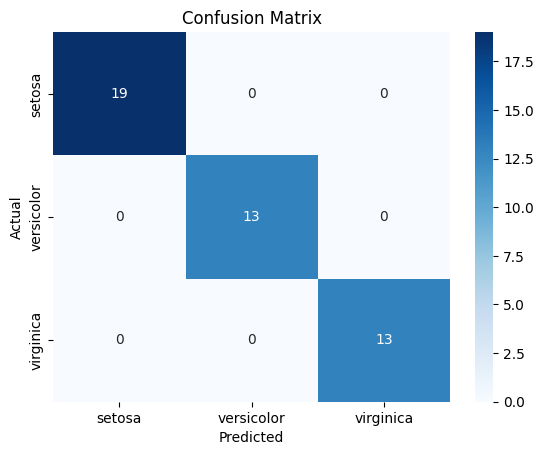

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=iris.target_names, yticklabels=iris.target_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()